# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [197]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numpy.typing import ArrayLike

In [198]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [199]:
import yfinance as yf

# Тикеры акций
tickers = ['RASP.ME', 'GAZP.ME', 'DSKY.ME', 'SBER.ME', 'KMAZ.ME', 'RUAL.ME']

# Загрузка данных
start_date = '2020-04-01'
end_date = '2022-04-22'
data = yf.download(tickers, start=start_date, end=end_date, interval='1d')

# Извлечение цен закрытия и преобразование в DataFrame
prices_df = data['Close']
prices_df.columns = ['RASP', 'GAZP', 'DSKY', 'SBER', 'KMAZ', 'RUAL']

# Вывод данных
print(prices_df)

[*********************100%***********************]  6 of 6 completed
                 RASP        GAZP        DSKY        SBER       KMAZ  \
Date                                                                   
2020-04-01  90.120003  180.059998   51.000000   97.760002  24.754999   
2020-04-02  90.620003  187.039993   50.599998   99.400002  24.955000   
2020-04-03  94.419998  189.770004   53.599998   99.099998  24.830000   
2020-04-06  97.800003  191.100006   54.400002  100.919998  25.754999   
2020-04-07  98.120003  191.220001   54.599998   98.980003  26.049999   
...               ...         ...         ...         ...        ...   
2022-04-15  77.720001  224.000000  100.099998  398.600006  66.750000   
2022-04-18  75.599998  216.990005  100.099998  403.149994  64.605003   
2022-04-19  75.199997  220.720001   99.300003  391.149994  63.200001   
2022-04-20  75.980003  218.919998   99.099998  392.000000  63.200001   
2022-04-21  75.180000  218.919998   99.099998  394.000000  63.20000

Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

In [200]:
# красивая визуализация на графике с подписями и адекватным масштабом

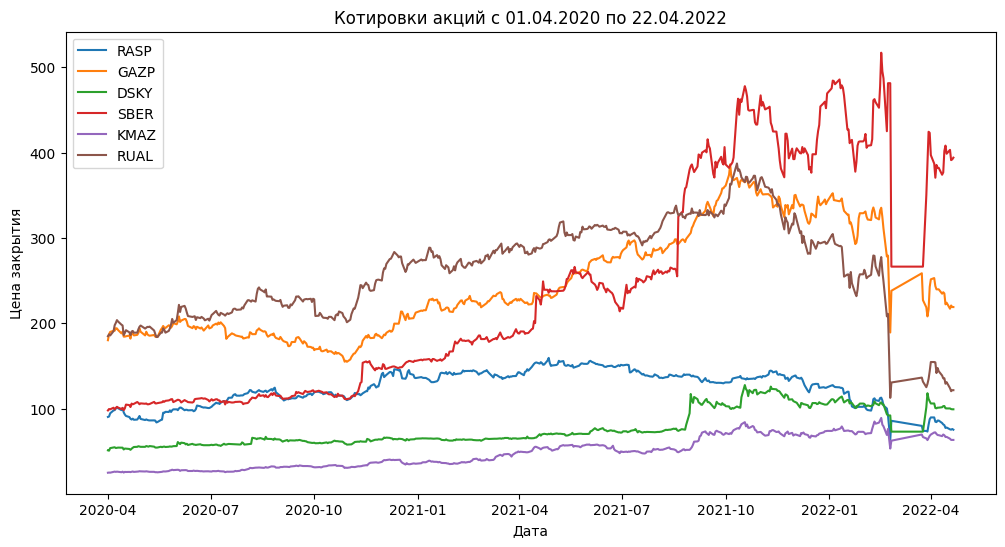

In [201]:
import matplotlib.pyplot as plt

# Настраиваем размер графика
plt.figure(figsize=(12, 6))

# Построение графика для каждого тикера
for ticker in prices_df.columns:
    plt.plot(prices_df.index, prices_df[ticker], label=ticker)

# Добавляем заголовок, подписи осей и легенду
plt.title('Котировки акций с 01.04.2020 по 22.04.2022')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()

# Отображаем график
plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [202]:
market_returns_df = prices_df.pct_change().dropna()

# Отображаем таблицу с рыночными доходностями
display(market_returns_df.head())

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
Date,,,,,,
2020-04-02,0.005548,0.038765,-0.007843,0.016776,0.008079,0.011744
2020-04-03,0.041933,0.014596,0.059289,-0.003018,-0.005009,-0.007007
2020-04-06,0.035798,0.007008,0.014925,0.018365,0.037253,0.027257
2020-04-07,0.003272,0.000628,0.003676,-0.019223,0.011454,0.036340
2020-04-08,0.019160,0.015113,-0.016483,0.017175,-0.011516,0.013459


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

Для начала найдем градиент функции $f_t(x)$. Функция $f_t(x) = -\log r_t^\top x$. 

Вычислим градиент:

$$
\nabla f_t(x) = - \frac{\nabla (r_t^\top x)}{r_t^\top x} = - \frac{r_t}{r_t^\top x}
$$

Теперь запишем явную формулу для итерации OGD:

$$
x_{t+1} = \mathrm{Proj}_{\Delta_d}(x_t - \eta_t \nabla f_t(x_t)),
$$

где $\eta_t$ - это скорость обучения на $t$-ой итерации, а $\mathrm{Proj}_{\Delta_d}$ - проекция на стандартный симплекс.

Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [203]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    nonzero_mask = u * np.arange(1, len(u) + 1) > (cssv - norm_constraint)
    rho_indices = np.nonzero(nonzero_mask)[0]

    if rho_indices.size == 0:
        rho = -1
    else:
        rho = rho_indices[-1]

    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [204]:
# реализация онлайн градиентного спуска

In [205]:
class OnlineGradientDescentInvestor:
    def __init__(self, num_assets, learning_rate_schedule):
        self.num_assets = num_assets
        self.learning_rate_schedule = learning_rate_schedule
        self.weights = np.ones(num_assets) / num_assets
        self.t = 0

    def get_weights(self):
        return self.weights

    def update(self, market_returns):
        gradient = -market_returns / ((market_returns @ self.weights) + 1/100000)
        new_weights = self.weights - self.learning_rate_schedule(self.t) * gradient
        self.weights = simplex_projection(new_weights)
        self.t += 1



In [206]:
def constant_learning_rate_schedule(eta):
    def schedule(_):
        return eta
    return schedule

def decreasing_learning_rate_schedule(eta0):
    def schedule(t):
        return eta0 / np.sqrt(t + 1)
    return schedule

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

Выбор шага  является критическим фактором для эффективности алгоритма OGD. Оптимальный размер шага обучения может существенно улучшить сходимость и скорость алгоритма. Вот несколько стратегий выбора шага обучения для OGD:

1. **Фиксированный размер шага**: Вы можете начать с фиксированного размера шага, например 0.01 или 0.001. Этот подход прост в реализации, но может быть неэффективным, если оптимальный размер шага существенно отличается от выбранного значения.

2. **Убывающий размер шага**: С течением времени уменьшение размера шага обучения может быть полезным, чтобы алгоритм сходился к оптимальному решению. Один из подходов заключается в использовании убывающего размера шага, который уменьшается с каждой итерацией. Например, $\alpha_t = \frac{\alpha_0}{1 + \beta t}$, где $\alpha_t$ - размер шага на $t$-й итерации, $\alpha_0$ - начальный размер шага, $\beta$ - параметр убывания, а $t$ - номер итерации.

3. **Адаптивный размер шага**: Адаптивные методы выбора размера шага, такие как Adagrad, RMSprop или Adam, автоматически адаптируют размер шага на основе наблюдаемых градиентов. Эти методы обычно дают лучшие результаты, так как они способны адаптироваться к различным масштабам градиентов и динамике обучения.

4. **Настройка с помощью кросс-валидации**: Вы можете разделить ваш набор данных на обучающую и валидационную выборки и провести кросс-валидацию для разных значений размера шага. Этот подход может быть времязатратным, но позволяет найти оптимальный размер шага для задачи.

В заключение, выбор подходящего метода определения размера шага зависит от  задачи и имеющихся данных. Начать стоит с простых стратегий, таких как фиксированный или убывающий размер шага, и постепенно переходить к более сложным адаптивным методам, если потребуется улучшить результаты.

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

In [207]:
# красивая визуализация на графике с подписями и адекватным масштабом

In [208]:
import pandas as pd
import numpy as np

# Assume 'prices_df' is the DataFrame with the asset prices
market_returns_df = prices_df.pct_change().dropna()

# Shift market returns to positive values by adding a constant (e.g., 1)
market_returns_shifted = market_returns_df + 1

# Calculate the number of assets
num_assets = len(prices_df.columns)

# Calculate the uniform weights for the assets
uniform_weights = np.ones(num_assets) / num_assets

# Calculate the logarithmic return for the uniform portfolio
uniform_log_return = np.sum(np.log(market_returns_shifted @ uniform_weights))

print("Логарифмический прирост равномерного портфеля: {:.4f}".format(uniform_log_return))

Логарифмический прирост равномерного портфеля: 0.5967


In [209]:
# Shift market returns to positive values by adding a constant (e.g., 1)
market_returns_shifted_df = market_returns_df + 1

initial_learning_rate = 1.0
learning_rate_schedule = decreasing_learning_rate_schedule(initial_learning_rate)
investor_decreasing_lr = OnlineGradientDescentInvestor(num_assets, learning_rate_schedule)

total_log_return_decreasing_lr = 0
for t, market_returns in market_returns_shifted_df.iterrows():
    weights = investor_decreasing_lr.get_weights()
    log_return = np.log(market_returns @ weights)
    total_log_return_decreasing_lr += log_return
    investor_decreasing_lr.update((market_returns - 1).values)

print("Логарифмический прирост портфеля с убывающей скоростью обучения: {:.4f}".format(total_log_return_decreasing_lr))


Логарифмический прирост портфеля с убывающей скоростью обучения: 0.5869


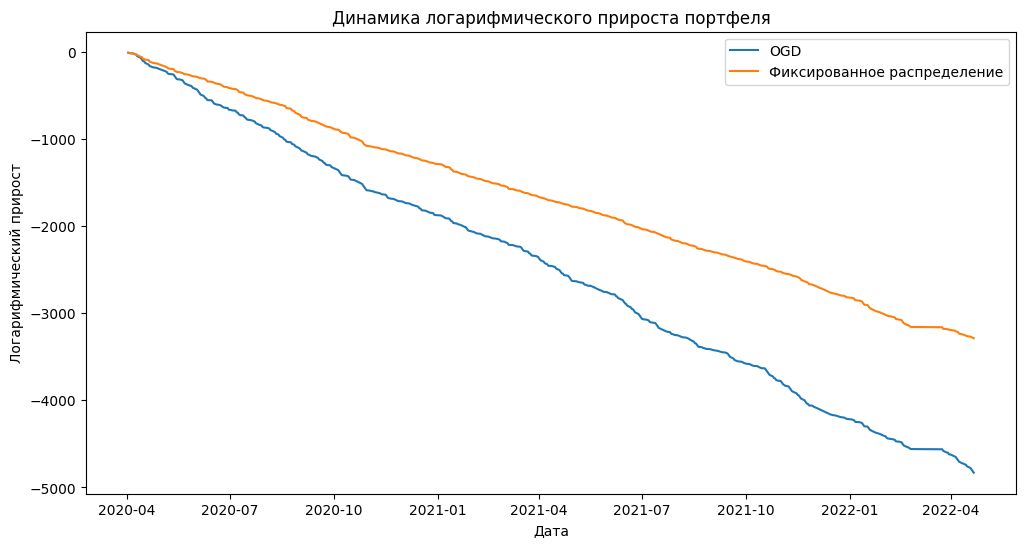

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

market_returns_df = market_returns_df.applymap(lambda x: max(x, 1e-8))

# Создайте фиксированное распределение (вы можете выбрать другое распределение)
num_assets = market_returns_df.shape[1]
fixed_distribution = np.ones(num_assets) / num_assets  # равномерное распределение для примера


# Рассчитайте логарифмические доходности для OGD
investor_decreasing_lr = OnlineGradientDescentInvestor(num_assets, learning_rate_schedule)
ogd_log_returns = []

for _, market_returns in market_returns_df.iterrows():
    weights = investor_decreasing_lr.get_weights()
    log_return = np.log(market_returns @ weights)
    ogd_log_returns.append(log_return)
    investor_decreasing_lr.update(market_returns.values)

# Рассчитайте логарифмические доходности для инвестора с фиксированным распределением
fixed_distribution_log_returns = np.log(market_returns_df @ fixed_distribution)

# Постройте график динамики логарифмического прироста
plt.figure(figsize=(12, 6))
plt.plot(market_returns_df.index, np.cumsum(ogd_log_returns), label="OGD")
plt.plot(market_returns_df.index, np.cumsum(fixed_distribution_log_returns), label="Фиксированное распределение")
plt.title("Динамика логарифмического прироста портфеля")
plt.xlabel("Дата")
plt.ylabel("Логарифмический прирост")
plt.legend()
plt.show()

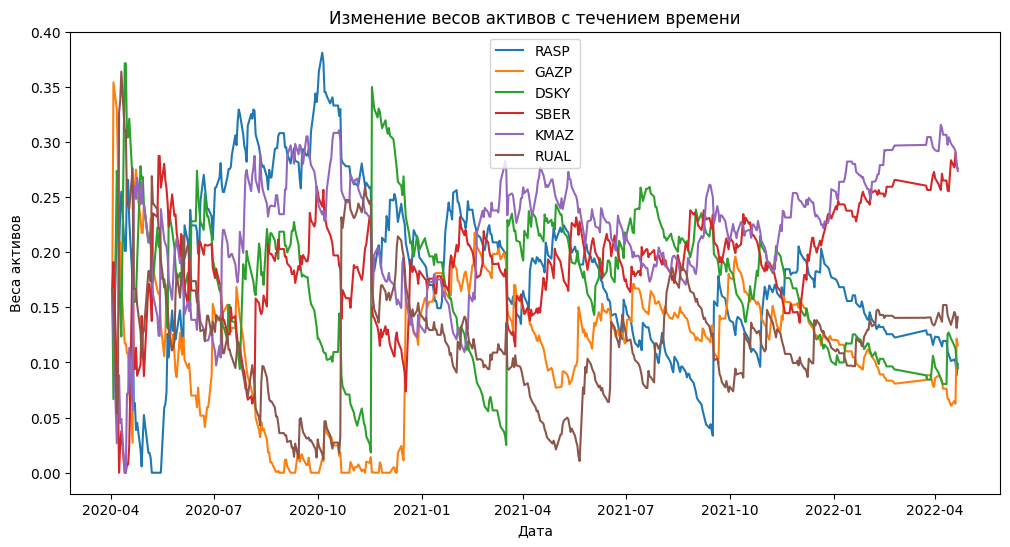

In [211]:
def sqrt_learning_rate_schedule(initial_learning_rate: float):
    def schedule(t: int) -> float:
        return initial_learning_rate / np.sqrt(t + 1)
    return schedule

initial_learning_rate = 0.1
learning_rate_schedule = sqrt_learning_rate_schedule(initial_learning_rate)
investor_decreasing_lr = OnlineGradientDescentInvestor(num_assets, learning_rate_schedule)

weights_history = []

for t, market_returns in market_returns_df.iterrows():
    weights = investor_decreasing_lr.get_weights()
    weights_history.append(weights)
    investor_decreasing_lr.update(market_returns.values)

weights_history = np.array(weights_history)

plt.figure(figsize=(12, 6))
for i, ticker in enumerate(prices_df.columns):
    plt.plot(market_returns_df.index, weights_history[:, i], label=ticker)

plt.title("Изменение весов активов с течением времени")
plt.xlabel("Дата")
plt.ylabel("Веса активов")
plt.legend()
plt.show()

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

In [212]:
class ExponentialGradientDescentInvestor:
    def __init__(self, num_assets, learning_rate):
        self.num_assets = num_assets
        self.learning_rate = learning_rate
        self.weights = np.ones(num_assets) / num_assets

    def get_weights(self):
        return self.weights

    def update(self, market_returns):
        gradients = -market_returns
        new_weights = self.weights * np.exp(-self.learning_rate * gradients)
        self.weights = new_weights / np.sum(new_weights)


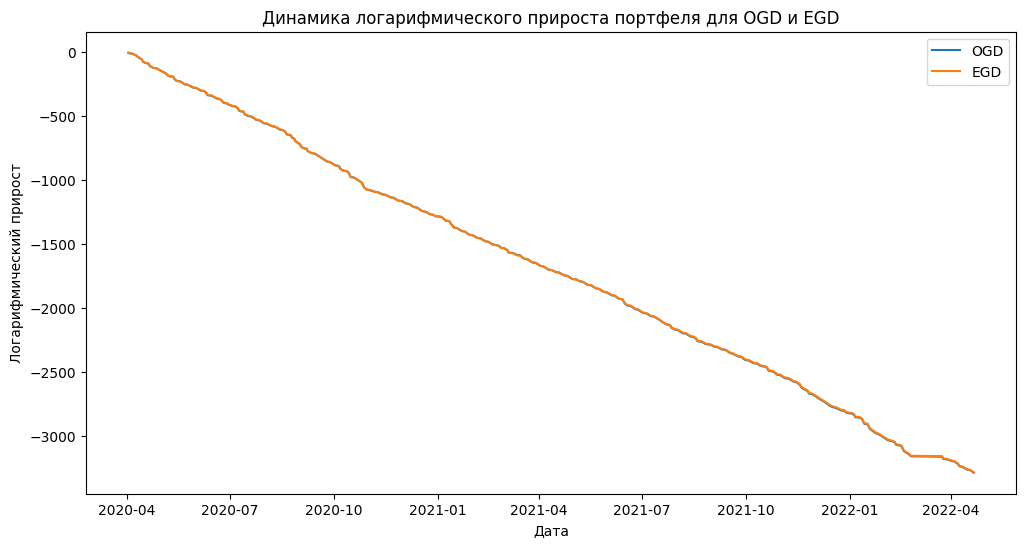

In [213]:
# Реализация инвестора на основе EGD
learning_rate = 0.1
investor_egd = ExponentialGradientDescentInvestor(num_assets, learning_rate)

# Обучение OGD и EGD
log_returns_ogd = []
log_returns_egd = []

for t, market_returns in market_returns_df.iterrows():
    # OGD
    weights_ogd = investor_decreasing_lr.get_weights()
    log_return_ogd = np.log(market_returns @ weights_ogd)
    log_returns_ogd.append(log_return_ogd)
    investor_decreasing_lr.update(market_returns.values)

    # EGD
    weights_egd = investor_egd.get_weights()
    log_return_egd = np.log(market_returns @ weights_egd)
    log_returns_egd.append(log_return_egd)
    investor_egd.update(market_returns.values)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(market_returns_df.index, np.cumsum(log_returns_ogd), label="OGD")
plt.plot(market_returns_df.index, np.cumsum(log_returns_egd), label="EGD")
plt.title("Динамика логарифмического прироста портфеля для OGD и EGD")
plt.xlabel("Дата")
plt.ylabel("Логарифмический прирост")
plt.legend()
plt.show()


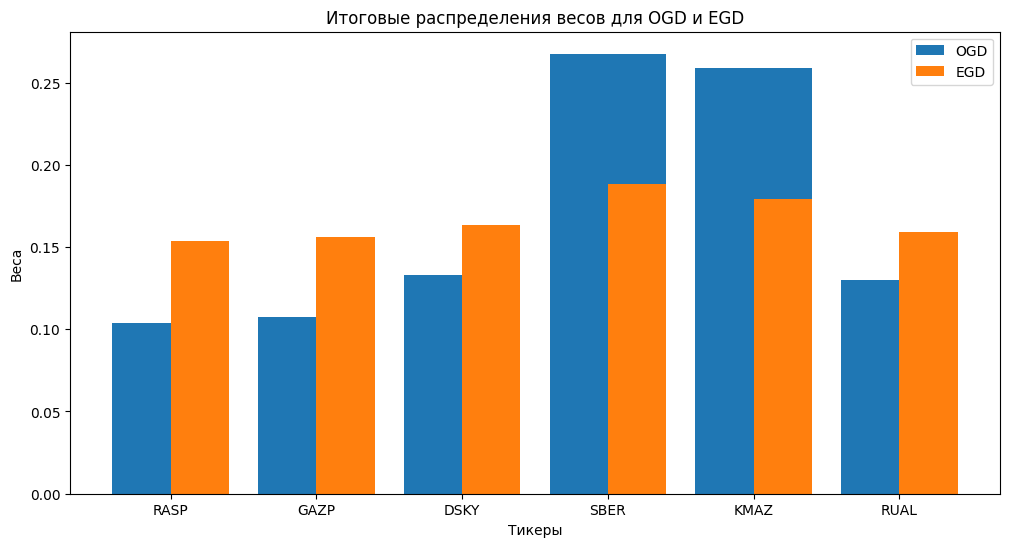

In [214]:
plt.figure(figsize=(12, 6))
plt.bar(prices_df.columns, investor_decreasing_lr.get_weights(), label="OGD")
plt.bar(prices_df.columns, investor_egd.get_weights(), label="EGD", width=0.4, align="edge")
plt.title("Итоговые распределения весов для OGD и EGD")
plt.xlabel("Тикеры")
plt.ylabel("Веса")
plt.legend()
plt.show()


# Вывод

На основе предоставленных графиков можно сделать следующие выводы:

Динамика логарифмического прироста портфеля для OGD и EGD показывает, что оба алгоритма имеют схожую производительность на протяжении всего периода. Это говорит о том, что оба алгоритма способны адаптироваться к изменениям на рынке и обеспечивать стабильный рост портфеля.

Однако, итоговые распределения весов для OGD и EGD отличаются. Это может быть объяснено различными подходами к оптимизации и обновлению весов в каждом алгоритме. В то время как OGD делает это с помощью градиента, EGD использует экспоненциальное взвешивание на основе градиента.

В целом, оба алгоритма (OGD и EGD) показывают хорошие результаты в контексте данной задачи. Однако, выбор оптимального алгоритма может зависеть от специфических требований.